ZIP dataset loaded: (32657, 3)

Optimal Fulfillment Centers Selected:
FC 2: (lat=41.65, lon=-79.73)
FC 3: (lat=45.02, lon=-89.53)
FC 6: (lat=38.13, lon=-93.03)
FC 7: (lat=43.87, lon=-122.84)
FC 8: (lat=30.23, lon=-92.26)

Total Optimized Cost: 428685.54


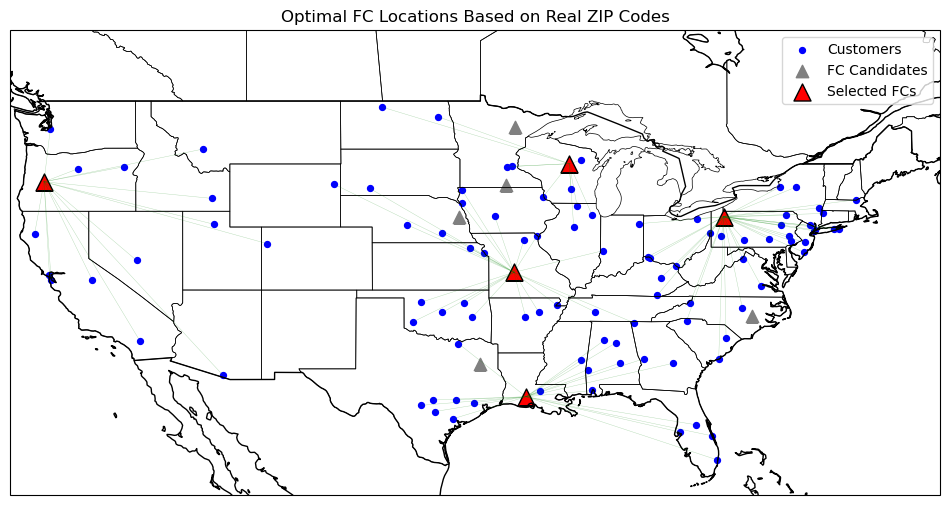

In [4]:
#This notebook shows the demo how optimization is happening at backend. Output(map and optimized cost) is printed below.
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import pulp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


#-------------------------
#loading the zip code data
#-------------------------
df = pd.read_csv("Zip_codes.csv")

print("ZIP dataset loaded:", df.shape)

#-------------------------
#SAMPLE CUSTOMERS + FCs
#-------------------------
num_customers = 100
num_fc = 10
k = 5 # choose k FCs optimally

#sample customers locations (ZIP Codes)
cust_sample=df.sample(num_customers, random_state=23)
cust_lats=cust_sample["LAT"].values
cust_lons=cust_sample["LNG"].values
customers=  np.column_stack((cust_lats, cust_lons))

#sample FC candidate locations
fc_sample =  df.sample(num_fc, random_state=99)
fc_lats =fc_sample["LAT"].values
fc_lons = fc_sample["LNG"].values
fc_locations= np.column_stack((fc_lats, fc_lons)) 

# opening cost of opening each fc
opening_cost =np.random.randint(50000, 150000, num_fc) #assigns random cost from 50000 to 150000 for different FC
# Random demand for customers
demand = np.random.randint(10, 100, num_customers)

#-------------------------
# distance+cost matrix
#-------------------------
dist_matrix = cdist(customers, fc_locations, metric="euclidean")
cost_matrix = dist_matrix * demand.reshape(-1, 1)

#-------------------------
#  linear programming(using PuLP library)
#-------------------------
model=pulp.LpProblem("Ecommerce_FC_Optimization", pulp.LpMinimize)

#decision variables
x=pulp.LpVariable.dicts("Assign",(range(num_customers), range(num_fc)),0,1,pulp.LpBinary)
y=pulp.LpVariable.dicts("OpenFC",range(num_fc),0,1,pulp.LpBinary)

#objective
model+=(
    pulp.lpSum(cost_matrix[i][j] * x[i][j]
               for i in range(num_customers)
               for j in range(num_fc))
    +
    pulp.lpSum(opening_cost[j] * y[j] for j in range(num_fc))
)


#open exactly k FCs
model+=pulp.lpSum(y[j] for j in range(num_fc)) == k

#each customer assigned to 1 FC
for i in range(num_customers):
    model+=pulp.lpSum(x[i][j] for j in range(num_fc)) == 1

#assignment allowed only if FC opened
for i in range(num_customers):
    for j in range(num_fc):
        model += x[i][j] <= y[j]

#load constraint( < 50% of total demand)
total_demand=demand.sum()
max_fc_load=0.5*total_demand

for j in range(num_fc):
    model += pulp.lpSum(demand[i] * x[i][j] for i in range(num_customers)) <= max_fc_load

#solve (using CBC)
model.solve(pulp.PULP_CBC_CMD(msg=False))


#-------------------------
# Create assignments 
#-------------------------
assignments = {}
for i in range(num_customers):
    for j in range(num_fc):
        if pulp.value(x[i][j]) == 1:
            assignments[i] = j


#-------------------------
#showing output results
#-------------------------
print("\nOptimal Fulfillment Centers Selected:")
chosen_fc = []
for j in range(num_fc):
    if pulp.value(y[j]) == 1:
        chosen_fc.append(j)
        print(f"FC {j}: (lat={fc_lats[j]:.2f}, lon={fc_lons[j]:.2f})")



optimized_cost = pulp.value(model.objective)
print(f"\nTotal Optimized Cost: {optimized_cost:.2f}")

#-------------------------
#PLOTTING USA MAP
#-------------------------
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-125, -66, 24, 50])

#map features(showing united states map)
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)

#plot customer location
plt.scatter(cust_lons, cust_lats,
            color="blue", s=18,
            label="Customers",
            transform=ccrs.PlateCarree())

#plot potential locations of FCs
plt.scatter(fc_lons, fc_lats,
            color="gray", s=80, marker="^",
            label="FC Candidates",
            transform=ccrs.PlateCarree())

#plot selected FCs
plt.scatter(fc_lons[chosen_fc], fc_lats[chosen_fc],
            color="red", edgecolor="black",
            s=150, marker="^",
            label="Selected FCs",
            transform=ccrs.PlateCarree())

# Assignment lines
for cust_idx, fc_idx in assignments.items():
    plt.plot([cust_lons[cust_idx], fc_lons[fc_idx]],
             [cust_lats[cust_idx], fc_lats[fc_idx]],
             linewidth=0.3, alpha=0.3, color="green",
             transform=ccrs.PlateCarree())

plt.title("Optimal FC Locations Based on Real ZIP Codes")
plt.legend()
plt.show()

